<a href="https://colab.research.google.com/github/GhaidaaShtayeh/spark-nlp-Pyspark/blob/master/spark-nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q pyspark==3.1.2 spark-nlp

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-2.3.0/spark-2.3.0-bin-hadoop2.7.tgz

!tar xf spark-2.3.0-bin-hadoop2.7.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-2.3.0-bin-hadoop2.7"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==2.7.5

import sparknlp

spark = sparknlp.start(spark23=True)

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [ ]:
import sparknlp

spark = sparknlp.start()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pandas as pd
import pyspark

spark = pyspark.sql.SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Assignment-BONUS") \
    .getOrCreate()
    
Data = spark.read.parquet("/content/drive/MyDrive/spark_nlp_dataset.parquet")

In [ ]:
Data.show(truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Reuters historical calendar - September 7 .                                                                                                                                                         |
|Following are some of the major events to have occurred on September 7 in history .                                                                                                                 |
|1714

In [ ]:
documentAssemble = DocumentAssembler().setInputCol('text').setOutputCol('document').setCleanupMode('shrink')

In [ ]:
sentenceDetector = SentenceDetector().setInputCols(['document']).setOutputCol('sentence')

In [ ]:
tokenizer = Tokenizer().setInputCols("document").setOutputCol("token")

In [ ]:
embedding = WordEmbeddingsModel.pretrained(lang="en")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
posTagger = PerceptronModel.pretrained(lang="en")

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]


In [ ]:
ner = NerCrfModel.pretrained(lang="en")

ner_crf download started this may take some time.
Approximate size to download 10.1 MB
[OK!]


In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages([documentAssemble, sentenceDetector, tokenizer, embedding, posTagger, ner])

In [ ]:
processed_data = pipeline.fit(Data).transform(Data)

In [ ]:
processed_data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 pos|                 ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Reuters historica...|[[document, 0, 42...|[[document, 0, 42...|[[token, 0, 6, Re...|[[word_embeddings...|[[pos, 0, 6, NNP,...|[[named_entity, 0...|
|Following are som...|[[document, 0, 82...|[[document, 0, 82...|[[token, 0, 8, Fo...|[[word_embeddings...|[[pos, 0, 8, VBG,...|[[named_entity, 0...|
|1714 - The Treaty...|[[document, 0, 12...|[[document, 0, 12...|[[token, 0, 3, 17...|[[word_embeddings...|[[pos, 0, 3, CD, ...|[[named_entity, 0...|
|1812 - Russian ar...|[[document, 0, 13...|[[document, 0, 13...|[[token, 0, 3, 18...|[[word_embeddings...|

In [ ]:
processed_data.select('pos', 'ner').limit(5).show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-

In [ ]:
processed_data.select('pos.result', 'ner.result').limit(2).show(truncate = False)

+----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|result                                                                                                    |result                                                                                                     |
+----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|[NNP, JJ, NN, -, NNP, CD, .]                                                                              |[I-ORG, O, O, O, O, O, O]                                                                                  |
|[VBG, VBP, DT, IN, DT, JJ, NNS, TO, VB, VBN, IN, NNP, CD, IN, NN, .]                                      |[O, O, O, O, O, O, O, O,

In [88]:
from pyspark.sql.functions import col
from pyspark.sql.functions import explode
ner = processed_data.select(explode("ner")).select(col("col.result").alias("ner"))
ner.show()

+-----+
|  ner|
+-----+
|I-ORG|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
+-----+
only showing top 20 rows



In [89]:
pos = processed_data.select(explode("pos")).select(col("col.result").alias("pos"))
pos.show()

+---+
|pos|
+---+
|NNP|
| JJ|
| NN|
|  -|
|NNP|
| CD|
|  .|
|VBG|
|VBP|
| DT|
| IN|
| DT|
| JJ|
|NNS|
| TO|
| VB|
|VBN|
| IN|
|NNP|
| CD|
+---+
only showing top 20 rows



In [68]:
POS = pos.toPandas()
NER = ner.toPandas()

In [69]:
dataFrame_combine= pd.DataFrame()
dataFrame_combine["ner"] =NER["ner"]
dataFrame_combine["pos"] =POS["pos"]

In [70]:
dataFrame_combine

,ner,pos
0,I-ORG,NNP
1,O,JJ
2,O,NN
3,O,-
4,O,NNP
...,...,...
26185,O,NNP
26186,O,:
26187,O,NNP
26188,O,NNP


##  result attribute of NER and POS, find a way to explain any relationship (if exists) between found entities and their part of speech attributes. 

In [122]:
import numpy as np
DataFrame_Grouping = dataFrame_combine.groupby(['ner', 'pos']).size().rename("count").reset_index()
x2 = dataFrame_combine.groupby(['ner']).size().rename("NERcount").reset_index()
x2
DataFrame_Grouping=DataFrame_Grouping.merge(x2)
DataFrame_Grouping.reset_index(inplace=True,drop=True)
DataFrame_Grouping['POS_Percent_For_NER']=np.round((DataFrame_Grouping['count']/DataFrame_Grouping['NERcount'])*100,2)
del DataFrame_Grouping['NERcount']
DataFrame_Grouping.sort_values(by=['ner','count'],ascending=False,inplace=True)
DataFrame_Grouping.reset_index(inplace=True,drop=True)
DataFrame_Grouping.head(20)

,ner,pos,count,POS_Percent_For_NER
0,O,NNP,3472,15.72
1,O,NN,2691,12.18
2,O,IN,2186,9.90
3,O,CD,1601,7.25
4,O,DT,1585,7.18
5,O,JJ,1348,6.10
6,O,VBD,1024,4.64
7,O,NNS,1020,4.62
8,O,.,997,4.51
9,O,",",823,3.73


#### Observe by looking at NER percentages which POS has most presence for a specific NER.
##### For example, if we are analyzing only for NER 'O', part of speech NNP, NN etc. combined together is more than 25%, hence it is very likely that NER 'O' is most likely a noun.

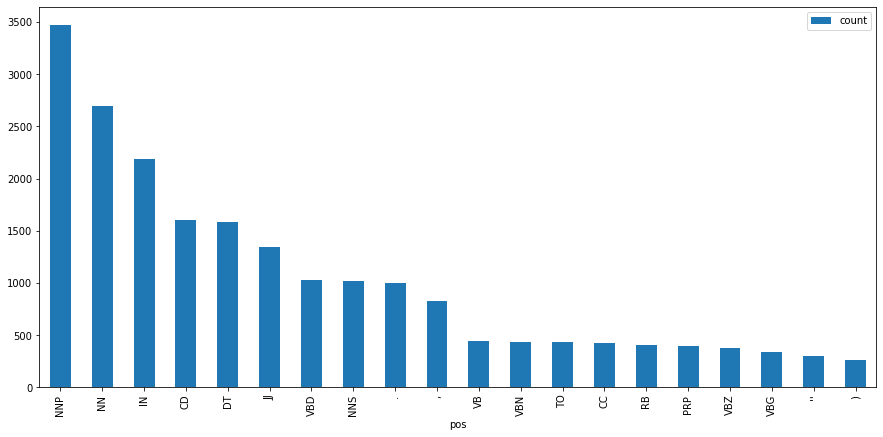

In [123]:
DataFrame_Grouping.iloc[0:20].plot(kind = "bar" , x = "pos" , y ="count" ,figsize=(15, 7))

## the most "O" catagorie represent **like** : 

In [125]:
#drop ner "O" to make tables more spesific and have meaning
rowsDeletion = DataFrame_Grouping[DataFrame_Grouping['ner']=="O" ].index.to_list()
dataFrame_combine_Without_O=DataFrame_Grouping.drop(rowsDeletion)
dataFrame_combine_Without_O.head(20)

,ner,pos,count,POS_Percent_For_NER
44,I-PER,NNP,490,33.65
45,I-PER,NN,146,10.03
46,I-PER,.,88,6.04
47,I-PER,IN,82,5.63
48,I-PER,CD,81,5.56
49,I-PER,(,77,5.29
50,I-PER,",",69,4.74
51,I-PER,JJ,60,4.12
52,I-PER,VBD,40,2.75
53,I-PER,NNS,39,2.68


#### now if we are analyzing this table , part of speech NNP, NN still take the top of percentage analysis combined together is more than 40%
###### and it's named entity regression as PERSON name and that the results make a lot of sense, hence it is very likely that NER "PER" is most likely a noun.

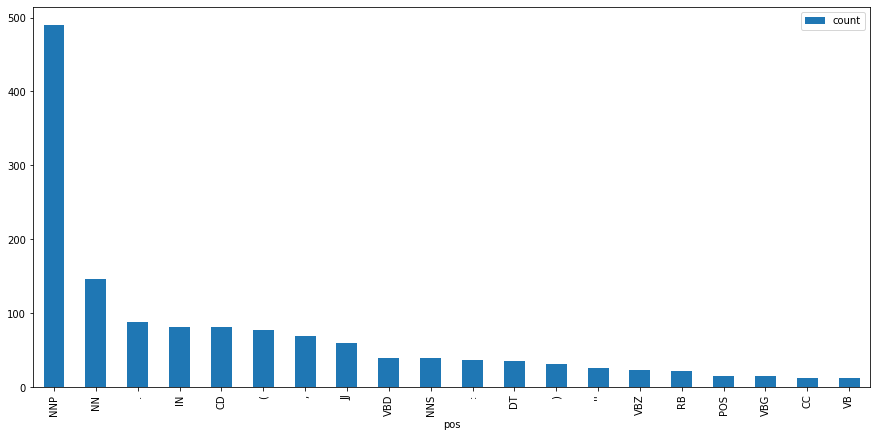

In [126]:
dataFrame_combine_Without_O.iloc[0:20].plot(kind = "bar" , x = "pos" , y ="count" ,figsize=(15, 7))

In [104]:
y = dataFrame_combine_Without_O.groupby(['ner']).sum('count')

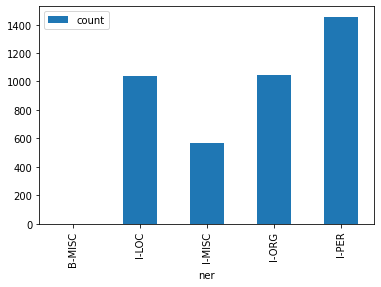

In [107]:
y.plot(kind= "bar", y = "count")

### Figure that **shows** most frequent NER Categorie appears :

In [109]:
z = dataFrame_combine_Without_O.groupby(['pos']).sum('count')

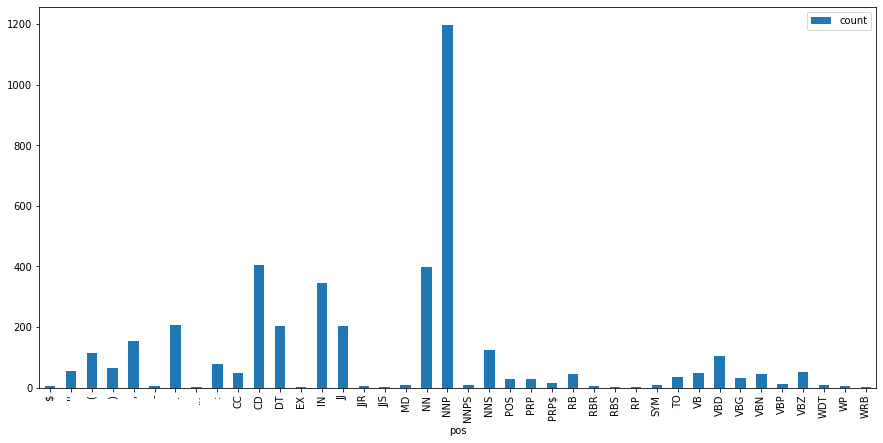

In [110]:
z.plot(kind= "bar", figsize=(15,7), y = "count")

## Figure that **shows** most frequent POS Categorie appears :